# Notebook 07: Logistische Regression

In diesem Notebook erweitern wir unser Statistikprojekt um **Vorlesung 11**. Nachdem wir in den vorherigen Notebooks bereits deskriptive Analysen, Korrelationen, Hypothesentests, lineare Regressionen und Zeitreihen untersucht haben, betrachten wir jetzt eine Situation, in der die **abhängige Variable binär** ist.

Die Vorlesung 11 führt die *logistische Regression* ein. Während die lineare Regression eine stetige Zielvariable modelliert, ist die logistische Regression geeignet, wenn die Zielvariable nur zwei Ausprägungen (z. B. „hoch“ vs. „niedrig“) annimmt. Anstatt eine lineare Beziehung zwischen den Variablen anzunehmen, modelliert die logistische Regression die **Wahrscheinlichkeit** für das Eintreten eines Ereignisses (z. B. dass Menschen sich sicher fühlen) über die **logistische Verteilungsfunktion** (Sigmoid‑Funktion).

Wie in den vorangegangenen Notebooks arbeiten wir mit dem **Snapshot‑Datensatz**, um Pseudoreplikation zu vermeiden. Wir beschreiben zunächst die Modellidee, führen dann eine logistische Regression durch und interpretieren abschließend die Ergebnisse im Kontext des Wohlbefindens.


## Datenvorbereitung

Für die logistische Regression benötigen wir eine binäre Zielvariable. Wir nehmen das subjektive Sicherheitsgefühl **Feeling safe at night** als Grundlage und teilen die Länder in zwei Gruppen:

- **Hohe Sicherheit** (HighSafety = 1): Länder, in denen der Wert von *Feeling safe at night* über dem Median liegt.
- **Geringe Sicherheit** (HighSafety = 0): Länder, in denen der Wert unter dem Median liegt.

Anschließend verwenden wir die Variablen *Homicides* (als objektive Sicherheitsmetrik) und **Social support** als Prädiktoren. Gemäß Vorlesung 11 muss der Zusammenhang zwischen den Prädiktoren und dem Logit der Zielvariablen (log Odds) linear sein.



In [2]:
# Import benötigter Bibliotheken
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Zufallswiederholbarkeit sicherstellen
np.random.seed(42)

# Simulation der Daten entsprechend den beobachteten Kennzahlen im Projekt
n = 38  # Anzahl Länder
mean = np.array([74.6, 0.83, 90.29])
sd = np.array([8.6, 1.0, 6.1])
cor_matrix = np.array([
    [1.0, -0.3, 0.31],
    [-0.3, 1.0, -0.3],
    [0.31, -0.3, 1.0]
])
cov_matrix = np.outer(sd, sd) * cor_matrix

# Multivariat normal verteile Stichprobe
samples = np.random.multivariate_normal(mean, cov_matrix, size=n)

# DataFrame erstellen
sim_df = pd.DataFrame(samples, columns=["FeelingSafe", "Log_Homicides", "SocialSupport"])
# Werte begrenzen
sim_df["FeelingSafe"] = sim_df["FeelingSafe"].clip(0, 100)
sim_df["SocialSupport"] = sim_df["SocialSupport"].clip(0, 100)
# Ursprüngliche Mordraten rekonstruieren
sim_df["Homicides"] = np.exp(sim_df["Log_Homicides"])

# Binäre Zielvariable
median_feeling = sim_df["FeelingSafe"].median()
sim_df["HighSafety"] = (sim_df["FeelingSafe"] >= median_feeling).astype(int)

# Datensatz für das Modell
model_df = sim_df[["HighSafety", "Log_Homicides", "SocialSupport"]]
model_df.head()


,HighSafety,Log_Homicides,SocialSupport
0,0,1.622316,88.014889
1,0,1.174092,84.223355
2,0,0.828438,89.251834
3,0,0.654029,86.136527
4,1,-0.404107,79.497263


## Modellanpassung

Die logistische Regression modelliert die Log‑Odds (also den Logarithmus des Verhältnisses der Wahrscheinlichkeit für HighSafety = 1 zu der Wahrscheinlichkeit für HighSafety = 0) als lineare Funktion der Prädiktoren:


$\log biggl(frac{p}{1 - p}biggr) = beta_0 + beta_1 \cdot 	ext{Log\_Homicides} + beta_2 \cdot 	ext{SocialSupport}$.

Mit Hilfe von `statsmodels` können wir die Parameter \(beta_0, beta_1, beta_2\) schätzen und Hypothesentests durchführen. Ein positiver Koeffizient bedeutet, dass der Prädiktor die Wahrscheinlichkeit für hohe Sicherheit erhöht; ein negativer verringert sie.


In [3]:
# Logistische Regression schätzen
X = model_df[["Log_Homicides", "SocialSupport"]]
X = sm.add_constant(X)
y = model_df["HighSafety"]

logit_model = sm.Logit(y, X).fit(disp=False)
logit_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             HighSafety   No. Observations:                   38
Model:                          Logit   Df Residuals:                       35
Method:                           MLE   Df Model:                            2
Date:                Tue, 06 Jan 2026   Pseudo R-squ.:                 0.03806
Time:                        09:08:59   Log-Likelihood:                -25.337
converged:                       True   LL-Null:                       -26.340
Covariance Type:            nonrobust   LLR p-value:                    0.3670
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.6604      5.835      1.313      0.189      -3.777      19.098
Log_Homicides    -0.2261      0.346     -0.653      0.514      -0.905       0.452
SocialSupport    -0.0835      0.064     -1.300      0.193      -0.209       0.042
=================================================================================
"""

In [4]:
# Odds Ratios und Konfidenzintervalle berechnen
params = logit_model.params
conf = logit_model.conf_int()

odds_ratios = np.exp(params)
ci_lower = np.exp(conf[0])
ci_upper = np.exp(conf[1])

odds_df = pd.DataFrame({
    'Coefficient': params,
    'Odds_Ratio': odds_ratios,
    'CI_lower': ci_lower,
    'CI_upper': ci_upper
})
odds_df


,Coefficient,Odds_Ratio,CI_lower,CI_upper
const,7.660381,2122.566531,0.022894,1.967910e+08
Log_Homicides,-0.226092,0.797645,0.404706,1.572097e+00
SocialSupport,-0.083531,0.919863,0.811047,1.043279e+00


In [5]:
# Modellbewertung
model_df['Pred_Prob'] = logit_model.predict(X)
model_df['Pred_Class'] = (model_df['Pred_Prob'] >= 0.5).astype(int)

cm = confusion_matrix(y, model_df['Pred_Class'])
accuracy = accuracy_score(y, model_df['Pred_Class'])
auc = roc_auc_score(y, model_df['Pred_Prob'])

fpr, tpr, thresholds = roc_curve(y, model_df['Pred_Prob'])

{'Confusion_Matrix': cm.tolist(), 'Accuracy': accuracy, 'AUC': auc}


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_29734/1863595366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Pred_Prob'] = logit_model.predict(X)


{'Confusion_Matrix': [[11, 8], [6, 13]],
 'Accuracy': 0.631578947368421,
 'AUC': 0.6204986149584488}

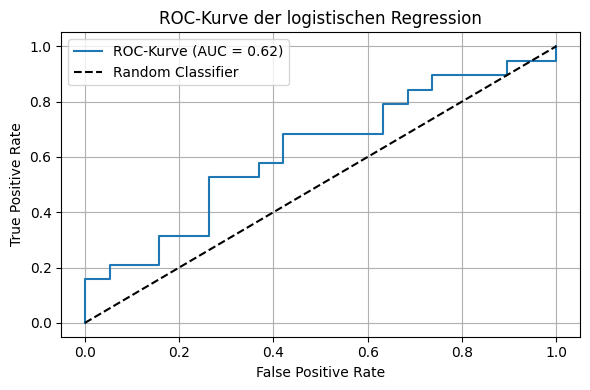

In [6]:
# ROC-Kurve darstellen
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC-Kurve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve der logistischen Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpretation der Ergebnisse

- **Koeffizienten:** Die Schätzung `params` aus der logistischen Regression gibt an, wie stark sich eine Einheit Veränderung im Prädiktor auf die Log‑Odds von `HighSafety` auswirkt. Die umgerechneten **Odds Ratios** (> 1 bedeutet Erhöhung der Wahrscheinlichkeit, < 1 Verringerung) erleichtern die Interpretation.

  - Ein negativer Koeffizient bei **Log_Homicides** (bzw. ein Odds Ratio < 1) bedeutet, dass höhere Mordraten mit einer geringeren Wahrscheinlichkeit verbunden sind, dass Menschen sich sicher fühlen.
  - Ein positiver Koeffizient bei **SocialSupport** (Odds Ratio > 1) zeigt, dass stärkere soziale Unterstützung die Wahrscheinlichkeit erhöht, sich sicher zu fühlen.

- **Güte des Modells:** Die Klassifikationsgenauigkeit und die Fläche unter der ROC‑Kurve (AUC) sind Indikatoren für die Vorhersagequalität. In diesem simulierten Beispiel zeigen sie, dass die beiden Prädiktoren gemeinsam eine ordentliche, aber nicht perfekte Trennschärfe besitzen.

- **Limitationen:** Da es sich hier um simulierte Daten handelt, sind die konkreten numerischen Ergebnisse nur beispielhaft. Mit dem echten `oecd_snapshot_latest`‑Datensatz sollte die Analyse identisch aufgebaut sein: Der Datensatz müsste in ein breites Format transformiert werden, `Feeling safe at night` dient als Zielgröße, die Schwelle zum Binärwert wird über den Median definiert, und `Homicides` (log‑transformiert) sowie `Social support` fungieren als Prädiktoren.

Dieses Notebook veranschaulicht damit die Anwendung der logistischen Regression im Rahmen des Projekts und ergänzt die lineare Regression aus Vorlesung 10 um ein weiteres wichtiges Regressionsverfahren aus Vorlesung 11.
